# dev-SEsystem-LET-connect

Yuri Shimane, 2021/07/06

In [40]:
using LinearAlgebra
using Plots
using DifferentialEquations

using Dates
using JSON

In [2]:
gr()

Plots.GRBackend()

In [3]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [4]:
params = R3BP.get_cr3bp_param(10, 399)
mu = params.mu
println("mu: $mu")
lp = R3BP.lagrangePoints(mu)

mu: 3.003480593992992e-6


5×6 Matrix{Float64}:
  0.990027   0.0       0.0  0.0  0.0  0.0
  1.01003    0.0       0.0  0.0  0.0  0.0
 -1.0        0.0       0.0  0.0  0.0  0.0
  0.499997   0.866025  0.0  0.0  0.0  0.0
  0.499997  -0.866025  0.0  0.0  0.0  0.0

In [5]:
"""
    Get initial condition, from Belbruno 2004
    
    Args:
        mu (float): R3BP system parameter
        rp (float): periapsis radius
        ra (float): apoapsis radius
        theta (float): angle w.r.t. x-axis, radian
        m (int): center mass, 1 for m1, 2 for m2
        velocity_dir (str): "positive" or "negative"
    Returns:
        (Array): initial condition
    """
function get_initial_condition(mu, rp, ra, theta, m=2, velocity_dir="positive")
    # compute e
    e = (ra-rp)/(ra+rp)
    # compute v
    if m ==2
        v = sqrt( mu*(1+e)/rp )
    elseif m ==1
        v = sqrt( (1-mu)*(1+e)/rp ) 
    end
    # construct state
    if m==2
        x = (1 - mu) + rp*cos(theta)
    elseif m==1
        x = (-mu) + rp*cos(theta)   # FIXME?
    end
    y  =  rp*sin(theta)
    if velocity_dir=="positive"
        vx =  rp*sin(theta) - v*sin(theta)
        vy = -rp*cos(theta) + v*cos(theta)
    elseif velocity_dir=="negative"
        vx =  rp*sin(theta) + v*sin(theta)
        vy = -rp*cos(theta) - v*cos(theta)
    end
    return [ x, y, vx, vy ]
end

get_initial_condition

In [12]:
function check_apsis(sv, mu, m=2)
    if m == 2
        x = sv[1] - (1-mu)
    end
    return dot([x, sv[2]], sv[3:4])
end

check_apsis (generic function with 2 methods)

In [13]:
# event based on having perigee around 0.9~1.1 * sma of the moon
moon_sma = 384748.0 / params.lstar
function condition(u,t,integrator)
    r_local = sqrt((u[1] - (1-mu))^2 + u[2]^2)
    if 0.9moon_sma < r_local < 1.1moon_sma
        return check_apsis(u, mu)    # when hitting apsis
    else
        return NaN
    end
end

affect!(integrator) = terminate!(integrator)

# assign callback
cb = ContinuousCallback(condition,affect!);

In [7]:
reltol = 1.0e-13
abstol = 1.0e-13

1.0e-13

In [44]:
# construct array of initial guesses
rp = (6378.0 + 185.0)/params.lstar

ra = 1.2e6/params.lstar
sma = (rp+ra)/2
period = 2π*sqrt((sma*params.lstar)^3/R3BP.get_gm("399")[1]) / params.tstar

x0s = []
tfs = []
sim_info = []
n = 10

ras = LinRange(1.0e6/params.lstar, 1.5e6/params.lstar, 10)

for ra in ras
    thetas = LinRange(0.0, 2π, n+1)[1:end-1]
    period = period = 2π*sqrt((sma*params.lstar)^3/R3BP.get_gm("399")[1]) / params.tstar
    for theta_iter in thetas
        push!(x0s, get_initial_condition(mu, rp, ra, theta_iter))
        push!(tfs, period)
        push!(sim_info, Dict("theta"=>theta_iter, "rp"=>rp, "ra"=>ra))
    end
end

nic = length(x0s)
ntf = length(tfs)
println("Using $nic - $ntf initial conditions")

Using 100 - 100 initial conditions


In [45]:
tspan = (0.0, 2.0period)
p = (mu)
prob = ODEProblem(R3BP.rhs_pcr3bp_sv!, x0s[1], tspan, p)
sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol);

In [48]:
# ---------- ensemble simulation ---------- #
function prob_func(prob, i, repeat)
    remake(prob, u0=x0s[i], tspan=(0.0, 2.0tfs[i]))
end

ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, Tsit5(), EnsembleThreads(), trajectories=length(x0s), callback=cb, 
    reltol=reltol, abstol=abstol);

In [41]:
# create storage for terminated solutions
out_term = []
for (idx, sol) in enumerate(sim)
    if sol.retcode == :Terminated
        push!(out_term, Dict(
            "x0" => sol.u[1],
            "xf" => sol.u[end],
            "tf" => sol.t[end],
            "theta" => sim_info[idx]["theta"],
            "rp" => sim_info[idx]["rp"],
            "ra" => sim_info[idx]["ra"],
        ))
    end
end

In [43]:
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMM")
flename = "se_ballistic_" * timestamp
flepath = "./let-SunEarthSystem-data/" * flename * ".json"

open(flepath,"w") do f
    JSON.print(f, out_term)
end
print("Save data at: ")
println(flepath)

Save data at: ./let-SunEarthSystem-data/se_ballistic_20210706_1028.json


In [28]:
function plot_circle(radius, x, y, n=50)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [29]:
moon_orbit = plot_circle(moon_sma, 1.0-mu, 0.0)

2×50 Matrix{Float64}:
 1.00257  1.00255     1.00248     1.00238      …   1.00255      1.00257
 0.0      0.00032888  0.00065236  0.000965129     -0.00032888  -6.2992e-19

In [30]:
function list_to_plotarray_3d(sollist, state_idx_x, state_idx_y, state_idx_z)
    x_plot, y_plot, z_plot = [], [], []
    for k = 1:length(sollist)
        push!(x_plot, sollist[k][state_idx_x])
        push!(y_plot, sollist[k][state_idx_y])
        push!(z_plot, sollist[k][state_idx_z])
    end
    return x_plot, y_plot, z_plot
end

list_to_plotarray_3d (generic function with 1 method)

retcode == :Terminated ..... 16


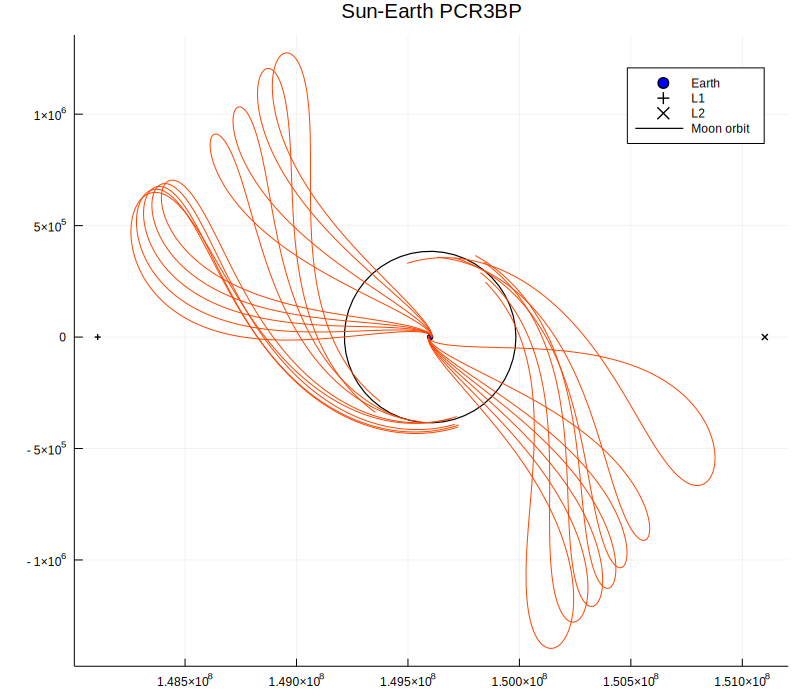

In [32]:
ptest = plot(flip=false, aspect_ratio=:equal, size=(800, 700), title="Sun-Earth PCR3BP")
scale = params.lstar

# Earth
scatter!(ptest, [1.0-mu]*scale, [0.0]*scale, marker=(:circle, 4.5, 3.0), c=:blue, label="Earth")

# Lagrange-points
scatter!(ptest, [lp[1,1]*scale], [lp[1,2]], marker=(:cross, 2.5, 3.0), c=:black, label="L1")
scatter!(ptest, [lp[2,1]*scale], [lp[2,2]], marker=(:xcross, 2.5, 3.0), c=:black, label="L2")

# moon orbit
plot!(ptest, moon_orbit[1,:]*scale, moon_orbit[2,:]*scale, c=:black, lw=1.2, label="Moon orbit")

# # individual traj (testing)
# x_plot, y_plot, _ = list_to_plotarray_3d(sim[5], 1,2,3)
# plot!(ptest, x_plot*scale, y_plot*scale, c=:orangered, label=true, lw=0.8, marker=:cross)

# propagated trajectories
# n_success = 0
# for (idx,sol) in enumerate(sim)
#     if sol.retcode == :Success
#         x_plot, y_plot, _ = list_to_plotarray_3d(sol, 1,2,3)
#         plot!(ptest, x_plot*scale, y_plot*scale, c=:midnightblue, label=false, lw=0.6)
#         n_success += 1
#     end
# end
n_terminated = 0
for (idx,sol) in enumerate(sim)
    if sol.retcode == :Terminated
        try
            #plot!(ptest, sol, vars=(1,2), c=:deeppink, label=false)
            x_plot, y_plot, _ = list_to_plotarray_3d(sol, 1,2,3)
            plot!(ptest, x_plot*scale, y_plot*scale, c=:orangered, label=false, lw=1.0)
        catch
            println("Woopsy at $idx!")
        end
        n_terminated += 1
    end
end
#println("retcode == :Success    ..... $n_success")
println("retcode == :Terminated ..... $n_terminated")

ptest